## Import the necessary packages

In [1]:
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt

## Hyperparameters

The first step is to set a random seed, and specify the number of discrete time steps at which the process will be observed. Furthermore, the number of paths to be simulated should be specified. The greater the number of paths, higher the accuracy of the model output. The terminal period for the model is the time to maturity of the option in days which has been set to 1.

In [2]:
np.random.seed(seed=13) 

N = 10000             # time steps 
paths = 10000               # number of paths
T = 1
T_vec, dt = np.linspace(0,T,N, retstep=True )
dt_sq = np.sqrt(dt)

## Parameters

The numerous parameters for the Heston model is specified. 

In [3]:
r = 0.05                                           # drift
rho = -0.8                                         # correlation coefficient
kappa = 3                                          # mean reversion coefficient
theta = 0.1                                        # long-term mean of the variance
sigma = 0.25                                       # (Vol of Vol) - Volatility of instantaneous variance
mu = 0.1
T = 1                                             # Terminal time
K = 100                                            # Stike  
v0 = 0.08                                          # spot variance
S0 = 100                                           # spot stock price 

Using log-variables is the best choice, because it avoids negative values without any tweak of the original process.
From the practical point of view, it is better not to use log-variables!
The reason is that the algorithm can produce NaNs or overflows when the time steps are not small enough (e.g. for N < 20000). This happens quite frequently.

In [4]:
X0 = np.log(S0)                                    # log price
Y0 = np.log(v0)                                    # log volatility
k = np.log(K/S0)                                   # Vol of Vol - Volatility of instantaneous variance
std_asy = np.sqrt( theta * sigma**2 /(2*kappa) )   # asymptotic standard deviation for the CIR process

The following Feller condition must be checked for the model parameters to assure that the model's output is valid. 

In [5]:
assert(2*kappa * theta > sigma**2)                 # Feller condition

There are two Brownian motions in the Heston model, the stock price, and the variance. The below code generates the Brownian motions. 

In [6]:
MU = np.array([0, 0])
COV = np.matrix([[1, rho], [rho, 1]])
W = ss.multivariate_normal.rvs( mean=MU, cov=COV, size=(paths,N-1) )
W_S = W[:,:,0]   # Stock Brownian motion:     W_1
W_v = W[:,:,1]   # Variance Brownian motion:  W_2

The simulated Heston paths must be saved of course! Initialize vectors to store the Heston path values. 

In [7]:
Y = np.zeros((paths,N))
Y[:,0] = Y0
X = np.zeros((paths,N))
X[:,0] = X0
v = np.zeros(N)

## Heston Path 

Loop over N to generate Heston paths and save them. 

In [8]:
for t in range(0,N-1):
    v = np.exp(Y[:,t])    # variance 
    v_sq = np.sqrt(v)     # square root of variance 
    
    Y[:,t+1] = Y[:,t] + (1/v)*( kappa*(theta - v) - 0.5*sigma**2 )*dt + sigma * (1/v_sq) * dt_sq * W_v[:,t]   
    X[:,t+1] = X[:,t] + (mu - 0.5*v)*dt + v_sq * dt_sq * W_S[:,t]

Take a look at the simulated heston stock price paths and the heston variance paths. 

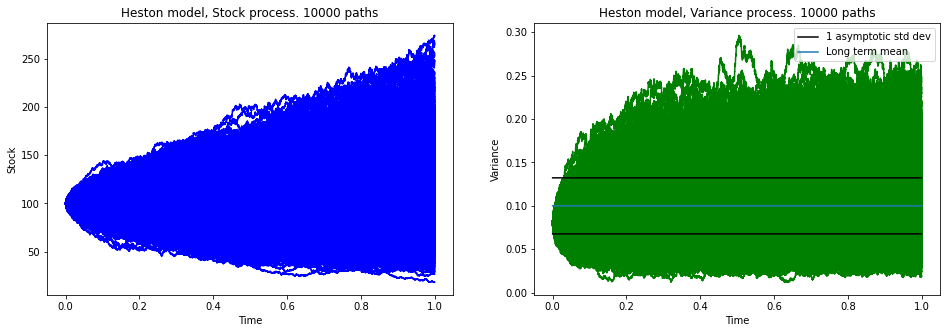

In [9]:
fig = plt.figure(figsize=(16,5))
ax1 = fig.add_subplot(121); ax2 = fig.add_subplot(122)

ax1.plot(T_vec, np.exp(X.T), 'b')
ax1.set_title("Heston model, Stock process. 10000 paths"); ax1.set_xlabel("Time"); ax1.set_ylabel("Stock")
ax2.plot(T_vec, np.exp(Y.T) , 'g')

ax2.set_title("Heston model, Variance process. 10000 paths"); ax2.set_xlabel("Time"); ax2.set_ylabel("Variance")
ax2.plot(T_vec, (theta + std_asy)*np.ones_like(T_vec), label="1 asymptotic std dev", color="black" )
ax2.plot(T_vec, (theta - std_asy)*np.ones_like(T_vec), color="black" )
ax2.plot(T_vec, theta*np.ones_like(T_vec), label="Long term mean" )
ax2.legend(loc="upper right"); 
plt.show()

## Option Price

To calculate the call option price with the specified parameters, the monte carlo method provides an easy way to arrive at the Heston model output. 

In [10]:
DiscountedPayoff = np.exp(-r*T) * np.maximum(np.exp(X.T)-K,0) 
V = np.mean( DiscountedPayoff )
std_err = ss.sem( DiscountedPayoff ,axis=None, ddof=0)
print("Heston Monte Carlo call price: ", V)
print("With standard error: ", std_err)

Heston Monte Carlo call price:  10.398631459223326
With standard error:  0.0015429080349344685
